The code is from https://ml-showcase.paperspace.com/projects/super-mario-bros-double-deep-q-network

Turotial that we followed is https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/

# Grid

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

In [2]:
def normalize(random_variable):
    max_value = max(random_variable)
    min_value = min(random_variable)
    return [(x - min_value)/(max_value - min_value) for x in random_variable]

def rolling_average(buffer, k):
    avg = []
    for i in range(0, len(buffer) - k, k):
        cur_avg = sum(buffer[i:i+k]) / k
        for j in range(k):
            avg.append(cur_avg)
    return normalize(avg)

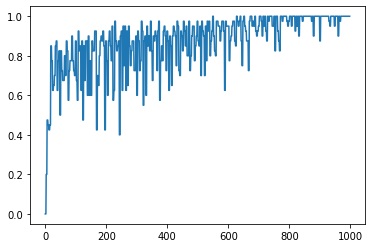

[['↓' '↗' '*']
 ['↗' '↗' '↑']
 ['↗' '↑' '→']]


In [3]:
class Grid():
    def __init__(self):
        self.state = None
        
    def reset(self):
        self.state = (2, 0)
        return self.state
        
    def step(self, action):
        # print(action)
        row_step = action[0]
        col_step = action[1]
        row = max(0, min(2, self.state[0] + row_step))
        col = max(0, min(2, self.state[1] + col_step))
        if (row, col) == (0, 2):
            reward = 0
            terminal = True
        else:
            reward = -1
            terminal = False
        self.state = (row, col)
        return (row, col), reward, terminal

class AgentQ():
    def __init__(self):
        self.gamma = 0.99
        self.alpha = 0.01
        self.q_table = np.zeros((9, 8))
        self.actions = [(a, b) for a in range(-1, 2) 
                                for b in range(-1, 2) 
                                 if (a,b) != (0,0)]
        self.exp_rate = 1
        self.decay = 0.99
    
    def act(self, state):
        if random.random() < self.exp_rate:
            action_id = random.randint(0, 7)
        else:
            state = state[0]*3 + state[1]
            action_id = np.random.choice(np.flatnonzero(self.q_table[state] == self.q_table[state].max()))
        
        self.exp_rate *= self.decay
        
        return action_id, self.actions[action_id]
    
    def q_update(self, state, action_id, reward, next_state, terminal):
        state = state[0]*3 + state[1]
        next_state = next_state[0]*3 + next_state[1]
        if terminal:
            target = reward
        else:
            target = reward + self.gamma*max(self.q_table[next_state])
        
        td_error = target - self.q_table[state, action_id]
        self.q_table[state, action_id] = self.q_table[state, action_id] + self.alpha*td_error
    
    def translate_action(self, action):
        if action == (-1, -1):
            return "↖"
        if action == (0, -1):
            return "←"
        if action == (1, -1):
            return "↙"
        if action == (1, 0):
            return "↓"
        if action == (1, 1):
            return "↘"
        if action == (0, 1):
            return "→"
        if action == (-1, 1):
            return "↗"
        if action == (-1, 0):
            return "↑"
    
    def best_policy(self):
        policy = np.zeros((3, 3), dtype='<U5')
        states = [(i,j) for i in range(3) for j in range(3)]
        for s in states:
            state = s[0]*3 + s[1]
            if s == (0, 2):
                policy[s] = "*"
            else:
                action_id = np.argmax(self.q_table[state])
                action = self.actions[action_id]
                policy[s] = self.translate_action(action)
        return policy

        
def train_agent():
    num_episodes = 1000
    agent = AgentQ()
    env = Grid()
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            action_id, action = agent.act(state)
            next_state, reward, terminal = env.step(action)
            episode_reward += reward
            
            agent.q_update(state, action_id, reward, next_state, terminal)
            state = next_state
            
            if terminal:
                break
        rewards.append(episode_reward)
    
    k = 3
    reward_plot = rolling_average(rewards, k)
    plt.plot(reward_plot)
    plt.show()
    
    return agent.best_policy()
print(train_agent())

[['↗' '↗' '*']
 ['↘' '↗' '↑']
 ['↗' '↓' '↓']]


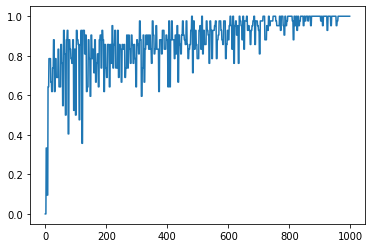

In [4]:
import copy 

class AgentQ():
    def __init__(self):
        self.gamma = 0.99
        self.alpha = 0.01
        self.q_table = np.zeros((9, 8))
        self.q_target = np.zeros((9, 8))
        self.actions = [(a, b) for a in range(-1, 2) 
                                for b in range(-1, 2) 
                                 if (a,b) != (0,0)]
        self.exp_rate = 1
        self.decay = 0.99
        self.copy_steps = 10
    
    def act(self, state):
        if random.random() < self.exp_rate:
            action_id = random.randint(0, 7)
        else:
            state = state[0]*3 + state[1]
            action_id = np.random.choice(np.flatnonzero(self.q_table[state] == self.q_table[state].max()))
        
        self.exp_rate *= self.decay
        
        return action_id, self.actions[action_id]
    
    def q_update(self, state, action_id, reward, next_state, terminal):
        state = state[0]*3 + state[1]
        next_state = next_state[0]*3 + next_state[1]
        if terminal:
            target = reward
        else:
            target = reward + self.gamma*max(self.q_target[next_state])
        
        td_error = target - self.q_table[state, action_id]
        self.q_table[state, action_id] = self.q_table[state, action_id] + self.alpha*td_error
    
    def copy(self):
        self.q_target = copy.deepcopy(self.q_table)
    
    def translate_action(self, action):
        if action == (-1, -1):
            return "↖"
        if action == (0, -1):
            return "←"
        if action == (1, -1):
            return "↙"
        if action == (1, 0):
            return "↓"
        if action == (1, 1):
            return "↘"
        if action == (0, 1):
            return "→"
        if action == (-1, 1):
            return "↗"
        if action == (-1, 0):
            return "↑"
    
    def best_policy(self):
        policy = np.zeros((3, 3), dtype='<U5')
        states = [(i,j) for i in range(3) for j in range(3)]
        for s in states:
            state = s[0]*3 + s[1]
            if s == (0, 2):
                policy[s] = "*"
            else:
                action_id = np.argmax(self.q_table[state])
                action = self.actions[action_id]
                policy[s] = self.translate_action(action)
        return policy
            
        
def train_agent_doubleq():
    num_episodes = 1000
    agent = AgentQ()
    env = Grid()
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        num_steps = 0
        while True:
            action_id, action = agent.act(state)
            next_state, reward, terminal = env.step(action)
            
            num_steps += 1
            if num_steps % agent.copy_steps == 0:
                agent.copy()
            
            episode_reward += reward
            
            agent.q_update(state, action_id, reward, next_state, terminal)
            state = next_state
            
            if terminal:
                break
            
        rewards.append(episode_reward)
    
    k = 3
    reward_plot = rolling_average(rewards, k)
    plt.plot(reward_plot)
    
    return agent.best_policy()
print(train_agent_doubleq())

# Mario Notebook

In [5]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 75 kB 1.5 MB/s 
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
     |████████████████████████████████| 964 kB 48.1 MB/s 
  Created wheel for nes-py: filename=nes_py-0.2.6-cp38-cp38-linux_x86_64.whl size=168653 sha256=1f18966919c936da54409fd8f671a2a169bbf266f3a3a660409d7ecb15a1c69c
  Stored in directory: /root/.cache/pip/wheels/3c/9a/a2/788fe13ef26f60ebbd806ed72432b284258f8a243557edc62e
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.1 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 50.4 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp38-cp38-linux_x86_64.whl size=438290 sha256=13778dddb159d6dda22f6ac8dc8cfcf09569b917cc9bb9acef1792704a7dd468
  St

In [6]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

In [7]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [8]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [9]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [10]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 10000
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
    
    if num_episodes > 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + 
                 np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()

run(training_mode=True, pretrained=False)

## Copyright

MIT License

Copyright (c) 2021 Gradient°

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.